<a href="https://colab.research.google.com/github/Amandine0610/project_sales_forecasting/blob/main/Summative_Intro_to_ml_%5BAmandineIrakoze%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2 ,l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# The Dataset
> ***Brief Description:***

***Problem Statement:*** Premium sporting goods lose 15–25% turnover due to inaccurate sales forecasting. The aim of the project is to predict if premium sports products will have high sales performance or not according to price, discount, marketing expenditure,
and seasonal factors.

***Dataset:*** Artificial premium sports sales with features like price, discount rate, marketing expenditure, seasonal factors, and binary target variable (high_sales: 1 for high sales, 0 for low sales).


In [ ]:
np.random.seed(42)
n_samples = 2000
data = {
    'price': np.random.uniform(100, 1000, n_samples),
    'discount': np.random.uniform(0, 50, n_samples),
    'marketing_spend': np.random.uniform(0, 10000, n_samples)
}
sales_score = (
    0.3 * (data['marketing_spend'] / 10000) +
    0.25 * (data['discount'] / 50) +
    0.2 * (1 - data['price'] / 1000) +
    0.25 * np.random.random(n_samples)
)
data['high_sales'] = (sales_score > np.median(sales_score)).astype(int)  # Binary target
df = pd.DataFrame(data)


print("Missing values:\n", df.isnull().sum())
df = df.dropna()

X = df[['price', 'discount', 'marketing_spend']].values
y = df['high_sales'].values
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 ≈ 15/(85)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("\nDataset Shapes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print("\nSummary Statistics:")
print(df.describe())

Missing values:
 price              0
discount           0
marketing_spend    0
high_sales         0
dtype: int64

Dataset Shapes:
Training set: (1399, 3)
Validation set: (301, 3)
Test set: (300, 3)

Summary Statistics:
             price     discount  marketing_spend   high_sales
count  2000.000000  2000.000000      2000.000000  2000.000000
mean    548.773236    24.819519      4962.849059     0.500000
std     262.989719    14.428995      2879.410507     0.500125
min     102.896437     0.000582         0.307188     0.000000
25%     314.241825    12.539338      2469.351321     0.000000
50%     556.616144    24.634716      4915.107461     0.500000
75%     775.610948    37.434525      7398.517782     1.000000
max     999.745906    49.977885      9993.503005     1.000000


#SECTION 1: Model Architecture:





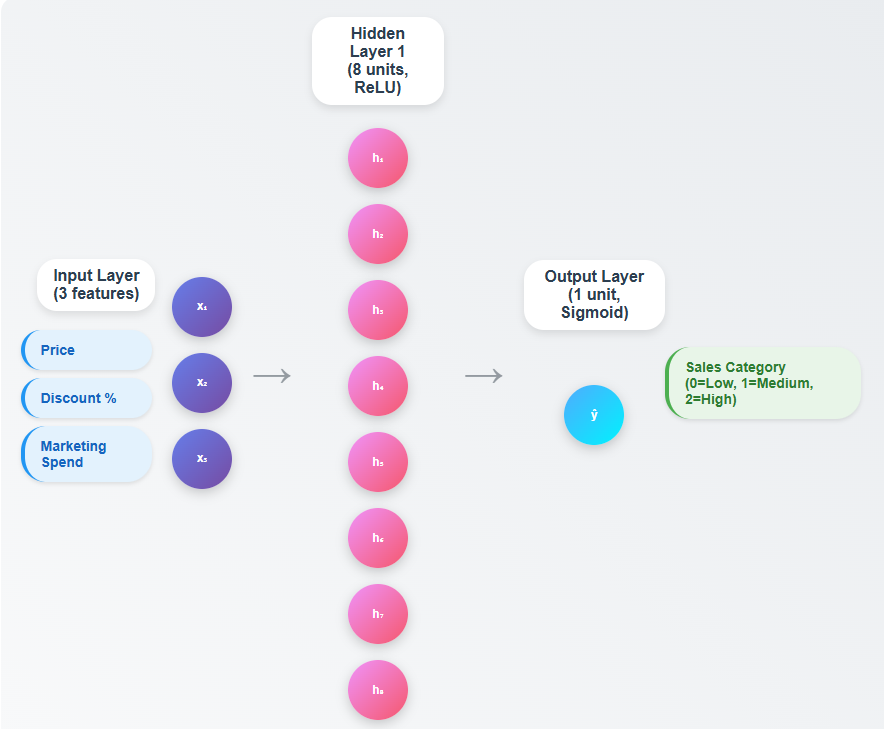

#Task: Define a function that creates models without and With specified Optimization techniques


In [ ]:
def define_model(optimizer_name='adam', regularizer=None, early_stopping=False, dropout_rate=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                        validation_split=0.2, callbacks=callbacks, verbose=1)
    return model, history


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def plot_loss_curves(history, title="Loss Curves"):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], 'b.', label='Training Loss')
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def compute_test_accuracy(model, X_test_scaled, y_test, threshold=0.5):
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_proba > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Training Model 1: Baseline


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


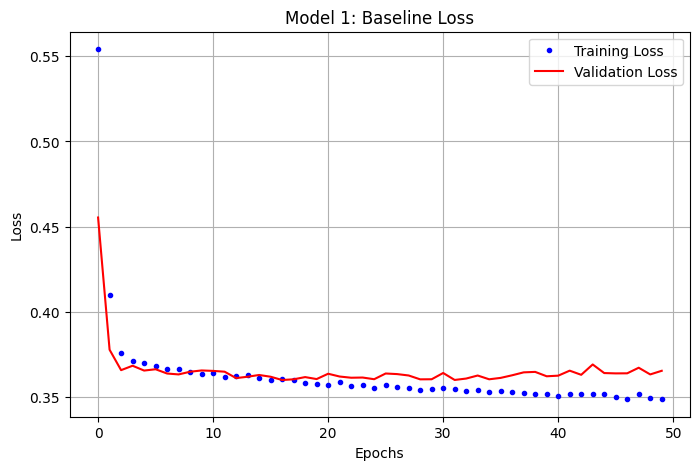

Test Accuracy: 0.8467


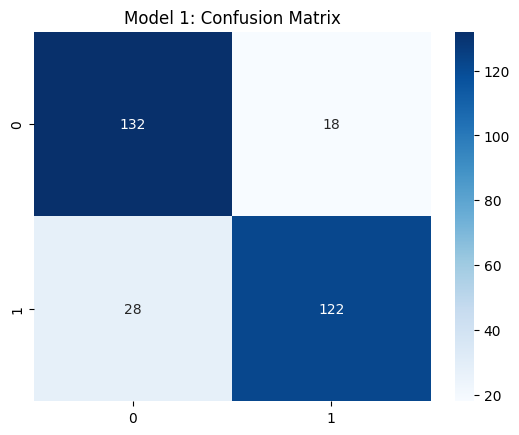


Training Model 2: Adam + L2 + Dropout + Early Stopping


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


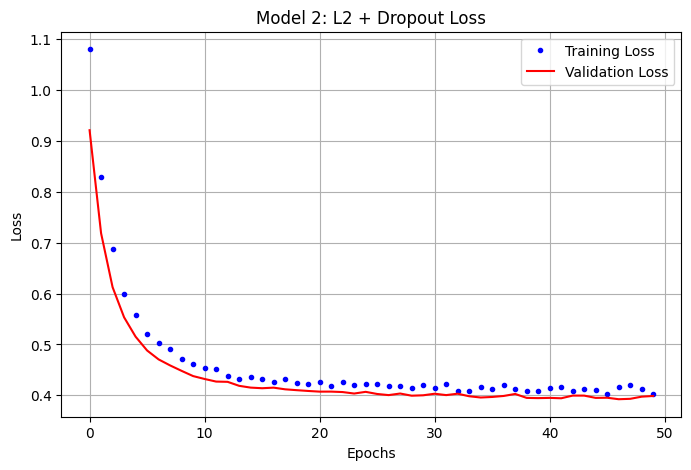

Test Accuracy: 0.8400


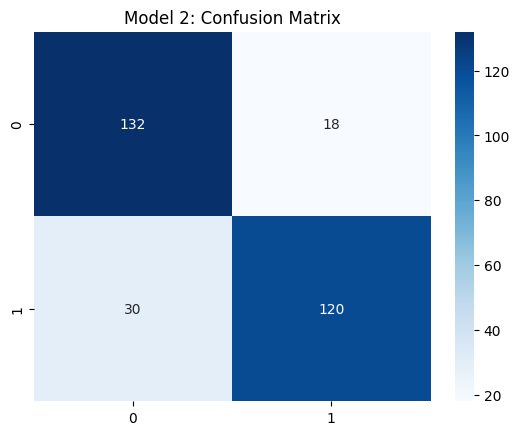


Training Model 3: RMSprop + L1 + Dropout


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


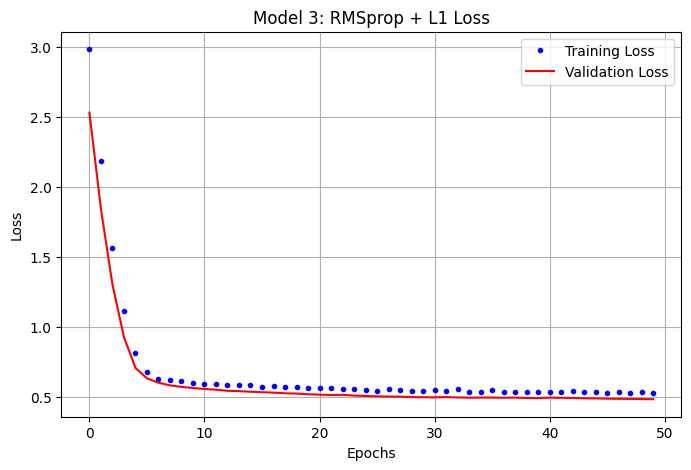

Test Accuracy: 0.8400


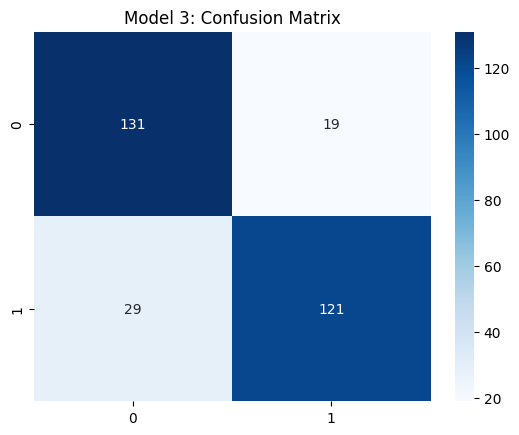


Training Model 4: Adam + L1/L2 + Early Stopping


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


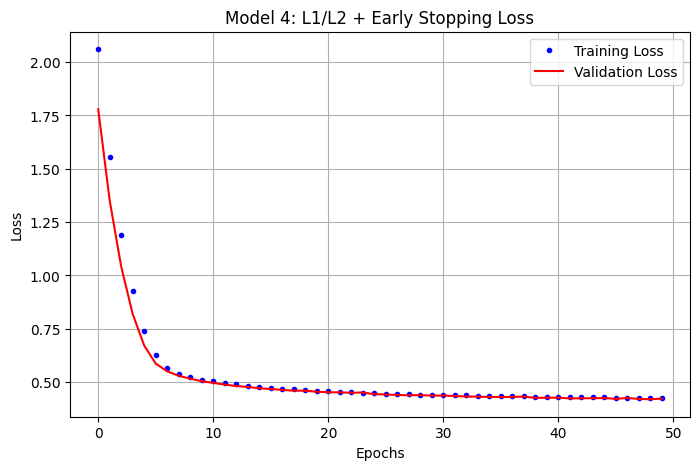

Test Accuracy: 0.8400


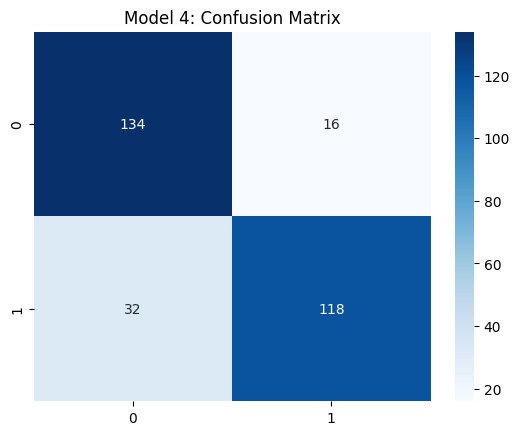


Optimization Results Table:
                    Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
0                Baseline    0.8467     0.8714  0.8133    0.8414   0.9318
1            L2 + Dropout    0.8400     0.8696  0.8000    0.8333   0.9313
2            RMSprop + L1    0.8400     0.8643  0.8067    0.8345   0.9301
3  L1/L2 + Early Stopping    0.8400     0.8806  0.7867    0.8310   0.9286


In [ ]:
results = []

# Model 1: Baseline
print("Training Model 1: Baseline")
model1, history1 = build_and_train_model()
plot_loss_curves(history1, "Model 1: Baseline Loss")
acc1 = compute_test_accuracy(model1, X_test_scaled, y_test)
y_pred1 = (model1.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba1 = model1.predict(X_test_scaled, verbose=0)
metrics1 = {
    'Model': 'Baseline',
    'Accuracy': acc1,
    'Precision': precision_score(y_test, y_pred1),
    'Recall': recall_score(y_test, y_pred1),
    'F1-Score': f1_score(y_test, y_pred1),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba1)
}
results.append(metrics1)
cm1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title("Model 1: Confusion Matrix")
plt.show()

# Model 2: Adam + L2 + Dropout + Early Stopping
print("\nTraining Model 2: Adam + L2 + Dropout + Early Stopping")
model2, history2 = build_and_train_model(
    regularizer=l2(0.01), dropout_rate=0.3, early_stopping=True
)
plot_loss_curves(history2, "Model 2: L2 + Dropout Loss")
acc2 = compute_test_accuracy(model2, X_test_scaled, y_test)
y_pred2 = (model2.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba2 = model2.predict(X_test_scaled, verbose=0)
metrics2 = {
    'Model': 'L2 + Dropout',
    'Accuracy': acc2,
    'Precision': precision_score(y_test, y_pred2),
    'Recall': recall_score(y_test, y_pred2),
    'F1-Score': f1_score(y_test, y_pred2),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba2)
}
results.append(metrics2)
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title("Model 2: Confusion Matrix")
plt.show()

# Model 3: RMSprop + L1 + Dropout
print("\nTraining Model 3: RMSprop + L1 + Dropout")
model3, history3 = build_and_train_model(
    optimizer_name='rmsprop', regularizer=l1(0.01), dropout_rate=0.3
)
plot_loss_curves(history3, "Model 3: RMSprop + L1 Loss")
acc3 = compute_test_accuracy(model3, X_test_scaled, y_test)
y_pred3 = (model3.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba3 = model3.predict(X_test_scaled, verbose=0)
metrics3 = {
    'Model': 'RMSprop + L1',
    'Accuracy': acc3,
    'Precision': precision_score(y_test, y_pred3),
    'Recall': recall_score(y_test, y_pred3),
    'F1-Score': f1_score(y_test, y_pred3),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba3)
}
results.append(metrics3)
cm3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title("Model 3: Confusion Matrix")
plt.show()

# Model 4: Adam + L1/L2 + Early Stopping
print("\nTraining Model 4: Adam + L1/L2 + Early Stopping")
model4, history4 = build_and_train_model(
    regularizer=l1_l2(l1=0.005, l2=0.005), early_stopping=True
)
plot_loss_curves(history4, "Model 4: L1/L2 + Early Stopping Loss")
acc4 = compute_test_accuracy(model4, X_test_scaled, y_test)
y_pred4 = (model4.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
y_pred_proba4 = model4.predict(X_test_scaled, verbose=0)
metrics4 = {
    'Model': 'L1/L2 + Early Stopping',
    'Accuracy': acc4,
    'Precision': precision_score(y_test, y_pred4),
    'Recall': recall_score(y_test, y_pred4),
    'F1-Score': f1_score(y_test, y_pred4),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba4)
}
results.append(metrics4)
cm4 = confusion_matrix(y_test, y_pred4)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues')
plt.title("Model 4: Confusion Matrix")
plt.show()


results_df = pd.DataFrame(results)
print("\nOptimization Results Table:")
print(results_df.round(4))


results_df.to_csv('optimization_results.csv', index=False)



#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest Model: {best_model_name} (F1-Score: {results_df.loc[best_model_idx, 'F1-Score']:.4f})")
best_model = [model1, model2, model3, model4][best_model_idx]
y_pred_best = (best_model.predict(X_test_scaled, verbose=0) > 0.5).astype(int)
print("\nSample Predictions (First 5):")
for i in range(5):
    print(f"Sample {i+1}: Features={X_test[i]}, Predicted={'High' if y_pred_best[i] else 'Low'}, True={'High' if y_test[i] else 'Low'}")


Best Model: Baseline (F1-Score: 0.8414)

Sample Predictions (First 5):
Sample 1: Features=[998.51276025  11.57376069 448.60557628], Predicted=Low, True=Low
Sample 2: Features=[104.55542546  14.61091152 860.32157033], Predicted=Low, True=Low
Sample 3: Features=[ 248.33333416   33.79114626 2330.18964397], Predicted=High, True=Low
Sample 4: Features=[ 172.82735475    8.67480252 5797.92843833], Predicted=High, True=High
Sample 5: Features=[ 965.95529363   31.03302399 6754.56045336], Predicted=High, True=High


Congratulations!!
